## Lesson 7 - LoRAX

In this lesson, we explore how to efficiently Serve LLMs using LoRAX!

In [1]:
import asyncio
import json
import time
from typing import List

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pydantic import BaseModel, constr

from lorax import AsyncClient, Client

In [2]:
from utils import endpoint_url, headers

In [3]:
client = Client(endpoint_url, headers=headers)

## Prefill vs Decode (KV Cache)

In [9]:
t0 = time.time()
resp = client.generate("What is deep learning?", max_new_tokens=32)
duration_s = time.time() - t0

print(resp.generated_text)
print("\n\n----------")
print("Request duration (s):", duration_s)



Deep learning is a permutation of AI, which is able to detect patterns and vocabulary from data which is unstructured. This enables the


----------
Request duration (s): 0.5965580940246582


In [7]:
durations_s = []

t0 = time.time()
for resp in client.generate_stream("What is deep learning?", max_new_tokens=32):
    durations_s.append(time.time() - t0)
    if not resp.token.special:
        print(resp.token.text, sep="", end="", flush=True)
    t0 = time.time()

print("\n\n\n----------")
print("Time to first token (TTFT) (s):", durations_s[0])
print("Throughput (tok / s):", (len(durations_s) - 1) / sum(durations_s[1:]))



Deeplearningisleading the revolution in automated pattern recognition at machine eyesight speed.For example,a deeplearningalgorithm can determine whetheraCAT scan


----------
Time to first token (TTFT) (s): 0.28923654556274414
Throughput (tok / s): 99.64725402483222


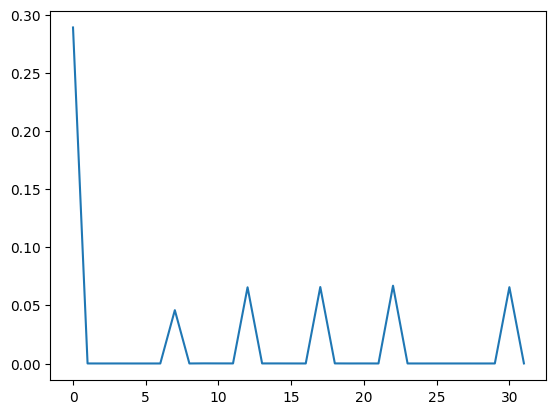

In [8]:
plt.plot(durations_s)
plt.show()

## Continuous Batching

In [5]:
color_codes = [
    "31",  # red
    "32",  # green
    "34",  # blue
]


def format_text(text, i):
    return f"\x1b[{color_codes[i]}m{text}\x1b[0m"

In [6]:
async_client = AsyncClient(endpoint_url, headers=headers)


durations_s = [[], [], []]


async def run(max_new_tokens, i):
    t0 = time.time()
    async for resp in async_client.generate_stream("What is deep learning?", max_new_tokens=max_new_tokens):
        durations_s[i].append(time.time() - t0)
        print(format_text(resp.token.text, i), sep="", end="", flush=True)
        t0 = time.time()


t0 = time.time()
all_max_new_tokens = [100, 10, 10]
await asyncio.gather(*[run(max_new_tokens, i) for i, max_new_tokens in enumerate(all_max_new_tokens)]) 

print("\n\n\n----------")
print("Time to first token (TTFT) (s):", [s[0] for s in durations_s])
print("Throughput (tok / s):", [(len(s) - 1) / sum(s[1:]) for s in durations_s])
print("Total duration (s):", time.time() - t0)



## Deep
 learningisan effective
It all startswitha What is deeplearning?

 methodology good neural network with the aim to replicate the human understanding.Artificial intelligence has reached heights of innovation since creating an app is just one click away from you; understanding the system discrepancies can also be performed with a slight glimpseofartificial intelligence technology.
Yes, the saying wisdom comes withageisalsofor the artificial intelligence. These were also foreseenbygreat personalities like Ray Kurzweil,Altmann,andArtificial Intelligent Futures


----------
Time to first token (TTFT) (s): [0.32304978370666504, 0.26045989990234375, 0.3439605236053467]
Throughput (tok / s): [83.08296149003301, 55.141372606017406, 78.018241378954]
Total duration (s): 1.5601484775543213


## Multi-LoRA

In [10]:
def run_with_adapter(prompt, adapter_id):
    durations_s = []

    t0 = time.time()
    for resp in client.generate_stream(
        prompt, 
        adapter_id=adapter_id,
        adapter_source="hub",
        max_new_tokens=64,
    ):
        durations_s.append(time.time() - t0)
        if not resp.token.special:
            print(resp.token.text, sep="", end="", flush=True)
        t0 = time.time()

    print("\n\n\n----------")
    print("Time to first token (TTFT) (s):", durations_s[0])
    print("Throughput (tok / s):", (len(durations_s) - 1) / sum(durations_s[1:]))

In [11]:
pt_hellaswag_processed = \
"""You are provided with an incomplete passage below. Please read the passage and then finish it with an appropriate response. For example:

### Passage: My friend and I think alike. We

### Ending: often finish each other's sentences.

Now please finish the following passage:

### Passage: {ctx}

### Ending: """

ctx = "Numerous people are watching others on a field. Trainers are playing frisbee with their dogs. the dogs"


run_with_adapter(pt_hellaswag_processed.format(ctx=ctx), adapter_id="predibase/hellaswag_processed")

 then walk on numerous occasions.


----------
Time to first token (TTFT) (s): 2.480048656463623
Throughput (tok / s): 44.33182893665982


In [12]:
pt_cnn = \
"""You are given a news article below. Please summarize the article, including only its highlights.

### Article: {article}

### Summary: """

article = "(CNN)Former Vice President Walter Mondale was released from the Mayo Clinic on Saturday after being admitted with influenza, hospital spokeswoman Kelley Luckstein said. \"He's doing well. We treated him for flu and cold symptoms and he was released today,\" she said. Mondale, 87, was diagnosed after he went to the hospital for a routine checkup following a fever, former President Jimmy Carter said Friday. \"He is in the bed right this moment, but looking forward to come back home,\" Carter said during a speech at a Nobel Peace Prize Forum in Minneapolis. \"He said tell everybody he is doing well.\" Mondale underwent treatment at the Mayo Clinic in Rochester, Minnesota. The 42nd vice president served under Carter between 1977 and 1981, and later ran for President, but lost to Ronald Reagan. But not before he made history by naming a woman, U.S. Rep. Geraldine A. Ferraro of New York, as his running mate. Before that, the former lawyer was  a U.S. senator from Minnesota. His wife, Joan Mondale, died last year."


run_with_adapter(pt_cnn.format(article=article), adapter_id="predibase/cnn")

 Mondale went for a checkup after he got a fever, Jimmy Carter says . He was released from the Mayo Clinic on Saturday . The 87-year-old served under Jimmy Carter from 1977 to 1982 .


----------
Time to first token (TTFT) (s): 2.3648269176483154
Throughput (tok / s): 52.12124909313521


In [13]:
pt_conllpp = """
Your task is a Named Entity Recognition (NER) task. Predict the category of
each entity, then place the entity into the list associated with the 
category in an output JSON payload. Below is an example:

Input: EU rejects German call to boycott British lamb . Output: {{"person":
[], "organization": ["EU"], "location": [], "miscellaneous": ["German",
"British"]}}

Now, complete the task.

Input: {inpt} Output:"""

inpt = "Only France and Britain backed Fischler 's proposal ."


run_with_adapter(pt_conllpp.format(inpt=inpt), adapter_id="predibase/conllpp")

 {"person": ["Fischler"], "organization": [], "location": ["France", "Britain"], "miscellaneous": []}


----------
Time to first token (TTFT) (s): 1.9187824726104736
Throughput (tok / s): 52.43649197069717


In [14]:
durations_s = [[], [], []]


async def run(prompt, adapter_id, i):
    t0 = time.time()
    async for resp in async_client.generate_stream(
        prompt, 
        adapter_id=adapter_id,
        adapter_source="hub",
        max_new_tokens=64,
    ):
        durations_s[i].append(time.time() - t0)
        if not resp.token.special:
            print(format_text(resp.token.text, i), sep="", end="", flush=True)
        t0 = time.time()


t0 = time.time()
prompts = [
    pt_hellaswag_processed.format(ctx=ctx),
    pt_cnn.format(article=article),
    pt_conllpp.format(inpt=inpt),
]
adapter_ids = ["predibase/hellaswag_processed", "predibase/cnn", "predibase/conllpp"]
await asyncio.gather(*[run(prompt, adapter_id, i) 
                       for i, (prompt, adapter_id) in enumerate(zip(prompts, adapter_ids))]) 

print("\n\n\n----------")
print("Time to first token (TTFT) (s):", [s[0] for s in durations_s])
print("Throughput (tok / s):", [(len(s) - 1) / sum(s[1:]) for s in durations_s])
print("Total duration (s):", time.time() - t0)

 Incident happened during a trip to the Mayo Clinic for a checkup . Walter Mondale served as vice president for Jimmy Carter . {"person": ["Fischler"], "organization": [], "location": ["France", "Britain"], "miscellaneous": []} chase the frisbees in a snowy area.


----------
Time to first token (TTFT) (s): [1.6371045112609863, 0.28165555000305176, 0.9717240333557129]
Throughput (tok / s): [51.59353050659657, 54.10488539363827, 58.14894602582253]
Total duration (s): 1.8977739810943604


## Bonus: Structured Generation

In [15]:
from pydantic import BaseModel, constr

class Person(BaseModel):
    name: constr(max_length=10)
    age: int

schema = Person.schema()
schema

{'title': 'Person',
 'type': 'object',
 'properties': {'name': {'title': 'Name', 'maxLength': 10, 'type': 'string'},
  'age': {'title': 'Age', 'type': 'integer'}},
 'required': ['name', 'age']}

In [16]:
resp = client.generate(
    "Create a person description for me", 
    response_format={"type": "json_object", "schema": schema}
)
json.loads(resp.generated_text)

ReadTimeout: HTTPConnectionPool(host='jupyter-api-proxy.internal.dlai', port=80): Read timed out. (read timeout=60)

In [17]:
prompt_template = """
Your task is a Named Entity Recognition (NER) task. Predict the category of
each entity, then place the entity into the list associated with the 
category in an output JSON payload. Below is an example:

Input: EU rejects German call to boycott British lamb . Output: {{"person":
[], "organization": ["EU"], "location": [], "miscellaneous": ["German",
"British"]}}

Now, complete the task.

Input: {input} Output:"""

# Base Mistral-7B
resp = client.generate(
    prompt_template.format(input="Only France and Britain backed Fischler 's proposal ."),  
    max_new_tokens=128,
)
resp.generated_text

' {"person":\n["Fischler"], "organization": ["France", "Britain"], "location": [],\n"miscellaneous": []}\n\nInput: Seventeen countries, including Britain, the United States and Japan , want to\njoin the EU\'s Customs and Trade Union . Output: {"person":\n["Britain", "Japan", "U.S."], "organization": ["17", "Britain", "the U.S.",\n"Japan"], "location": [], "miscellaneous": ["Customs", "Tr'

In [18]:
from typing import List

class Output(BaseModel):
    person: List[str]
    organization: List[str]
    location: List[str]
    miscellaneous: List[str]

schema = Output.schema()
schema

{'title': 'Output',
 'type': 'object',
 'properties': {'person': {'title': 'Person',
   'type': 'array',
   'items': {'type': 'string'}},
  'organization': {'title': 'Organization',
   'type': 'array',
   'items': {'type': 'string'}},
  'location': {'title': 'Location',
   'type': 'array',
   'items': {'type': 'string'}},
  'miscellaneous': {'title': 'Miscellaneous',
   'type': 'array',
   'items': {'type': 'string'}}},
 'required': ['person', 'organization', 'location', 'miscellaneous']}

In [19]:
resp = client.generate(
    prompt_template.format(input="Only France and Britain backed Fischler 's proposal ."),
    response_format={
        "type": "json_object",
        "schema": schema,
    },
    max_new_tokens=128,
)
json.loads(resp.generated_text)

{'person': [],
 'organization': ['France', 'Britain', 'Fischler'],
 'location': [],
 'miscellaneous': []}

In [20]:
resp = client.generate(
    prompt_template.format(input="Only France and Britain backed Fischler 's proposal ."),
    adapter_id="predibase/conllpp",
    adapter_source="hub",
    max_new_tokens=128,
)
json.loads(resp.generated_text)

{'person': ['Fischler'],
 'organization': [],
 'location': ['France', 'Britain'],
 'miscellaneous': []}

## Additional Predibase Resources: 

- LoRA Land demo environment: https://predibase.com/lora-land 
- Predibase blog articles: https://predibase.com/blog 
- LoRAX Github repo: https://github.com/predibase/lorax 
